In [2]:
import pandas as pd
import urllib.parse

START = "2024-01-01"
END = "2024-03-31"
LIMIT = 50000

base = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv"
where = f"created_date between '{START}T00:00:00' and '{END}T23:59:59'"
where_enc = urllib.parse.quote(where)

select = "unique_key,created_date,closed_date,agency,complaint_type,borough,latitude,longitude"
url = f"{base}?$where={where_enc}&$limit={LIMIT}&$select={select}"

print("Fetching data from:")
print(url)

df = pd.read_csv(url, parse_dates=["created_date", "closed_date"])
print(f"Loaded {len(df):,} rows")
df.head()


Fetching data from:
https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$where=created_date%20between%20%272024-01-01T00%3A00%3A00%27%20and%20%272024-03-31T23%3A59%3A59%27&$limit=50000&$select=unique_key,created_date,closed_date,agency,complaint_type,borough,latitude,longitude
Loaded 50,000 rows


,unique_key,created_date,closed_date,agency,complaint_type,borough,latitude,longitude
0,60740007,2024-03-31 23:59:36,2024-04-01 05:20:38,DOT,Street Sign - Damaged,BROOKLYN,40.693075,-73.959093
1,60734332,2024-03-31 23:59:09,2024-04-01 09:12:45,HPD,HEAT/HOT WATER,BRONX,40.811543,-73.924611
2,60738841,2024-03-31 23:58:47,2024-04-02 22:34:59,HPD,HEAT/HOT WATER,MANHATTAN,40.777070,-73.946274
3,60739109,2024-03-31 23:58:39,2024-04-02 15:08:50,DOT,Street Condition,MANHATTAN,40.725010,-73.979179
4,60735878,2024-03-31 23:58:32,2024-04-01 00:26:51,NYPD,Noise - Residential,BROOKLYN,40.659998,-73.960998


In [4]:

df = df.drop_duplicates(subset=["unique_key"])
df = df.dropna(subset=["created_date"])


df["response_time_hr"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 3600

df["borough"] = df["borough"].str.title()
df = df[df["response_time_hr"].notna()]
df.head()


,unique_key,created_date,closed_date,agency,complaint_type,borough,latitude,longitude,response_time_hr
0,60740007,2024-03-31 23:59:36,2024-04-01 05:20:38,DOT,Street Sign - Damaged,Brooklyn,40.693075,-73.959093,5.350556
1,60734332,2024-03-31 23:59:09,2024-04-01 09:12:45,HPD,HEAT/HOT WATER,Bronx,40.811543,-73.924611,9.226667
2,60738841,2024-03-31 23:58:47,2024-04-02 22:34:59,HPD,HEAT/HOT WATER,Manhattan,40.777070,-73.946274,46.603333
3,60739109,2024-03-31 23:58:39,2024-04-02 15:08:50,DOT,Street Condition,Manhattan,40.725010,-73.979179,39.169722
4,60735878,2024-03-31 23:58:32,2024-04-01 00:26:51,NYPD,Noise - Residential,Brooklyn,40.659998,-73.960998,0.471944


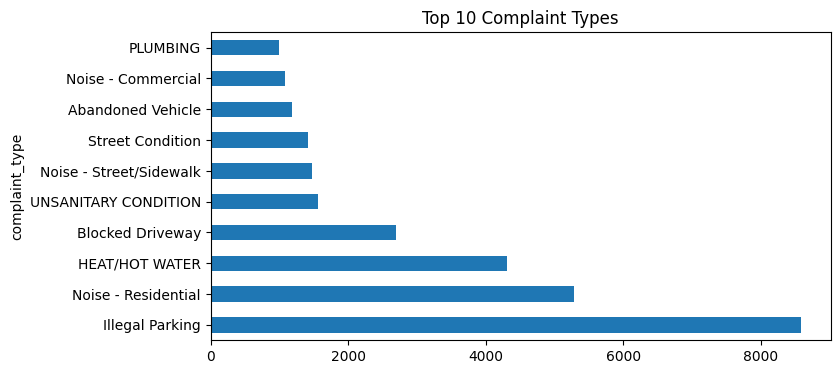

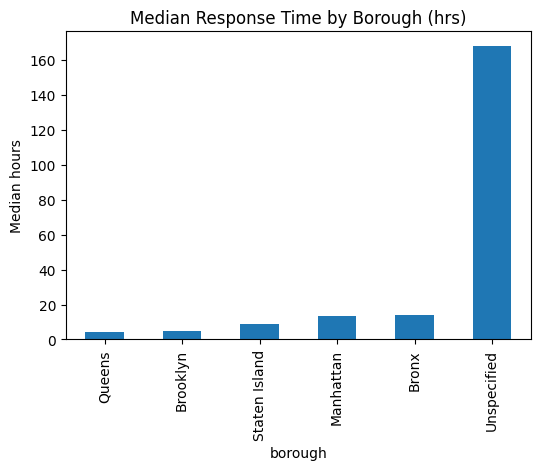

In [5]:

top_complaints = df["complaint_type"].value_counts().head(10)
top_complaints.plot(kind="barh", title="Top 10 Complaint Types", figsize=(8,4))
plt.show()

median_by_boro = df.groupby("borough")["response_time_hr"].median().sort_values()
median_by_boro.plot(kind="bar", title="Median Response Time by Borough (hrs)", figsize=(6,4))
plt.ylabel("Median hours")
plt.show()


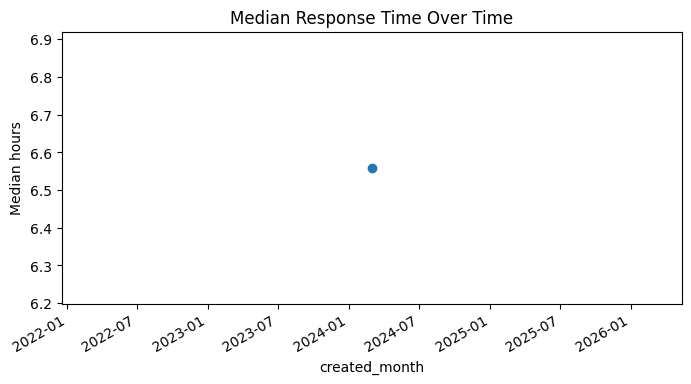

In [6]:
df["created_month"] = df["created_date"].dt.to_period("M").dt.to_timestamp()
trend = df.groupby("created_month")["response_time_hr"].median()
trend.plot(marker="o", title="Median Response Time Over Time", figsize=(8,4))
plt.ylabel("Median hours")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df["closed_within_48h"] = (df["response_time_hr"] <= 48).astype(int)

X = df[["agency", "complaint_type", "borough"]]
y = df["closed_within_48h"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["agency", "complaint_type", "borough"])
])

model = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=200))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
model.fit(X_train, y_train)
print("Accuracy:", model.score(X_test, y_test))


Accuracy: 0.8974758069973607
